# Creating own DAN 

In [1]:
import os
import tensorflow as tf
# from keras.layers import Layer
import numpy as np
import pandas as pd
from nltk.tokenize import word_tokenize
from typing import *
import pickle
import random
from nltk.tokenize import sent_tokenize
import seaborn as sns
import matplotlib.pyplot as plt

## Reading Data

In [2]:
data_dir = "../datasets/cleaned_datasets/filtered_dataset"

In [3]:
def read_data(_dir:str) -> pd.DataFrame:
    data = {}
    #data["url"] = []
    data["text"] = []
    data["class"] = []
    for root, dirs, files in os.walk(_dir):
        for _dir in dirs: 
            for txt_file in [x for x in os.listdir(os.path.join(root, _dir)) if x.endswith((".txt", ".TXT"))]:
                # Class name = dir name
                class_name = _dir
                #Read File
                file_name = os.path.abspath(os.path.join(root, _dir, txt_file))
                file = open(file_name, "r")
                txt = file.read()
                file.close()
                #data["url"].append(file_name)
                data["text"].append(txt)
                data["class"].append(class_name)
    df = pd.DataFrame.from_dict(data)
    del data
    return df

In [4]:
df = read_data(data_dir).sample(frac = 1)

In [5]:
df.head()

,text,class
154,in the present work the techniques of data min...,prediction
1044,but mere traditional urban and rural land clas...,prediction
2422,based on the class of algorithm to be used in ...,prediction
2900,however image clustering is a hard task mainly...,clustering
5589,frequent pattern mining based on linear prefix...,pattern_mining


## Creating One-Hot-Encodings

In [6]:
from sklearn import preprocessing

# Transform classes into dummies
le = preprocessing.LabelEncoder()

classes = df.drop(["text"], axis = 1)
classes.apply(le.fit_transform)

# Create One Hot Encodings
enc = preprocessing.OneHotEncoder()
enc.fit(classes)


one_hot_encodings = enc.transform(classes)

In [7]:
one_hot_encodings = one_hot_encodings.toarray()

In [8]:
df.shape

(9156, 2)

## Embeddings

In [9]:
class FastText():
    """
    Loads the FastText model and get the Vectors.
    """

    def __init__(self, **kwargs):
        # super().__init__(**kwargs)
        self.path = "/Users/Daniel/PycharmProjects/Recommender-System/notebooks/FastText/ft_model_15000.pkl"
        self.__initialize_model()

    def __initialize_model(self, **kwargs):
        try:
            tf.logging.info("FastText Model is loading")
            self.model = pickle.load(open(self.path, "rb"))
            tf.logging.info("FastText Model loaded!")
        except Exception as e:
            tf.logging.warning("Something went wrong while loading the FastText Model..")
            tf.logging.warning(e)

    def inference(self, words: List[str]) -> np.ndarray:
        embeddings = []
        for word in words:
            if self.model.wv.__contains__(word):
                embeddings.append(self.model.wv.__getitem__(word))
        return np.array(embeddings)


In [10]:
ft_path = "/Users/Daniel/PycharmProjects/Recommender-System/notebooks/FastText/ft_model_15000.pkl"
fast_text_model = FastText()

INFO:tensorflow:FastText Model is loading
INFO:tensorflow:FastText Model loaded!


## Creating Network Architecture

### Placeholder

In [11]:
x_input = tf.placeholder(dtype = tf.float64, shape = (None, 100), name = "placeholder_input")

In [12]:
y_true = tf.placeholder(dtype = tf.float64, shape = (None, 3), name = "placeholder_y_true")

### Costumized Layers

In [13]:
def dropout_layer(input_layer:np.ndarray ,dropout_prob:float = 0.2):
    #dist = tf.contrib.distributions.Binomial(1, self.drop)
    dist = 1 - np.random.binomial(1, dropout_prob, input_layer.shape[0])
    return input_layer[dist.astype(bool)]

In [14]:
def average_layer(placeholder: tf.Variable, name= "average_layer"):
    with tf.name_scope(name):
        average = tf.reduce_mean(input_tensor=placeholder, axis=0)
        return tf.reshape(average, (1,-1), name = "average_layer")

In [15]:
average = average_layer(x_input)

### Creating the Dense Layers for DAN

In [16]:
dense_layer_1 = tf.layers.dense(inputs=average,
                                      units=100,
                                      activation=tf.nn.tanh,
                                      use_bias=True,
                                      trainable=True,
                                      name="dense_layer_1")

In [17]:
dense_layer_2 = tf.layers.dense(inputs=dense_layer_1,
                                      units=100,
                                      activation=tf.nn.tanh,
                                      use_bias=True,
                                      trainable=True,
                                      name="dense_layer_2")

In [18]:
dense_layer_3 = tf.layers.dense(inputs=dense_layer_2,
                                      units=100,
                                      activation=tf.nn.tanh,
                                      use_bias=True,
                                      trainable=True,
                                      name="dense_layer_3")

In [19]:
dense_layer_4 = tf.layers.dense(inputs=dense_layer_3,
                                      units=100,
                                      activation=tf.nn.tanh,
                                      use_bias=True,
                                      trainable=True,
                                      name="dense_layer_4")

### Creating the Dense Layers for Clasification

In [20]:
dense_layer_5 = tf.layers.dense(inputs=dense_layer_4,
                                      units=200,
                                      activation=tf.nn.tanh,
                                      use_bias=True,
                                      trainable=True,
                                      name="dense_layer_5")

In [21]:
logits = tf.layers.dense(inputs=dense_layer_5,
                                      units=3,
                                      activation=tf.nn.tanh,
                                      use_bias=True,
                                      trainable=True,
                                      name="logits")

### Softmax Layer & Loss Function
https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits_v2

In [22]:
with tf.name_scope("loss"):
    softmax_layer = tf.nn.softmax_cross_entropy_with_logits_v2(labels = y_true, logits=logits) # WTF Is this function actually? 
    cross_entropy = tf.reduce_mean(softmax_layer)
    tf.summary.scalar("cross_entropy", cross_entropy)

### Optimizer

In [23]:
with tf.name_scope("train"):
    optimizer = tf.train.AdamOptimizer(learning_rate=1e-4)
    train = optimizer.minimize(cross_entropy)
    

### Metrics - Accuracy

In [24]:
with tf.name_scope("pred_eval"):
    prob_target = tf.argmax(logits, 1, name="prob_target") # Returns Index with largest value
    prob_true = tf.argmax(y_true, 1, name = "prob_true")
    pred_eval = tf.equal(prob_target, prob_true)
    
    #_sum = tf.add(predictions, tf.cast(correct_prediction, dtype=tf.float64))
    #correct_predictions = tf.concat(prob_target, prob_true)
    #correct_pred = tf.cast(correct_predictions, dtype=tf.int32)
    
    
    
    #correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y_true))
    #print("correct_prediction: {}".format(correct_prediction))
    
    #accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    #tf.summary.scalar("accuracy", accuracy)

## Saver

In [25]:
saver = tf.train.Saver()

In [26]:
save_path = "dan_checkpoints/" # Need to exist 

In [27]:
model_name = "first_dan.ckpt"

In [28]:
# Check the Graph
if not os.path.isdir(save_path):
    os.makedirs(save_path)

## Training

In [29]:
init = tf.global_variables_initializer()

10 Epoches rund 6 Minuten

In [30]:
%%time
with tf.Session() as sess: 
    sess.run(init)
    
    ### Tensorboard Stuff
    ## TODO at summary
    #merged_summary = tf.summary.merge_all()
    writer = tf.summary.FileWriter(save_path)
    writer.add_graph(sess.graph)

    epoches = 7
    
    preds = []
    for i in range(epoches):
        for j,p in enumerate([word_tokenize(x) for x in df["text"].tolist()]): 
            # Converting paragraphs to Embeddings
            embeddings = dropout_layer(fast_text_model.inference(p))
            label = np.array(one_hot_encodings[j]).reshape(1,-1)
            
            
            [_, _eval] = sess.run([train, pred_eval], feed_dict={x_input:embeddings, y_true:label})
            preds.append(_eval[0])
        print("Accuracy: {}".format(np.mean(preds)))
    saver.save(sess, os.path.join(save_path, model_name))
    print("model_saved!")
    sess.close()

Accuracy: 0.9322848405417212
Accuracy: 0.9415137614678899
Accuracy: 0.9444444444444444
Accuracy: 0.9472204019222368
Accuracy: 0.9490607252075142
Accuracy: 0.9508519003931848
Accuracy: 0.9515072083879423
model_saved!
CPU times: user 3min, sys: 15.8 s, total: 3min 16s
Wall time: 2min 24s


## Loading the Model

In [57]:
def get_dan_embedding(text: List[str], layer):
    with tf.Session() as sess: 
        saver.restore(sess,os.path.join(save_path, model_name))

        embeddings = fast_text_model.inference(text)
        
        dan_emb = sess.run(layer, feed_dict={x_input:embeddings})
        
        sess.close()
        return dan_emb

## Retrieving Embeddings for Examples

In [32]:
example_1 = "i want predict cost"
example_2 = "i want predict stock prize"
example_3 = "i want similar cost"
example_4 = "i want pattern in my costs"

examples = [example_1, example_2, example_3, example_4]

In [33]:
fastText_embeddings = [np.mean(fast_text_model.inference(word_tokenize(x)), axis = 0) for x in examples]

In [34]:
dan_embeddings = np.squeeze([get_dan_embedding(word_tokenize(x), layer = dense_layer_4) for x in examples]).tolist()

INFO:tensorflow:Restoring parameters from dan_checkpoints/first_dan.ckpt
INFO:tensorflow:Restoring parameters from dan_checkpoints/first_dan.ckpt
INFO:tensorflow:Restoring parameters from dan_checkpoints/first_dan.ckpt
INFO:tensorflow:Restoring parameters from dan_checkpoints/first_dan.ckpt


In [35]:
_df = pd.DataFrame.from_dict({"text": examples, "ft_embedding": fastText_embeddings, "dan_embedding": dan_embeddings})

## PCA

In [36]:
from sklearn.decomposition import PCA

In [37]:
pca_FT = PCA(n_components=2)
pca_DAN = PCA(n_components=2)

In [38]:
matrix_DAN = pca_FT.fit_transform(_df["dan_embedding"].tolist())

In [39]:
matrix_FT = pca_FT.fit_transform(_df["ft_embedding"].tolist())

In [40]:
_df["ft_x"] = matrix_FT[:,0]
_df["ft_y"] = matrix_FT[:,1]

In [41]:
_df["dan_x"] = matrix_DAN[:,0]
_df["dan_y"] = matrix_DAN[:,1]

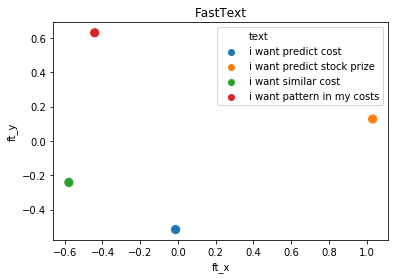

In [42]:
ax = sns.scatterplot(x = "ft_x", y="ft_y", data = _df, s = 100,  hue = "text")
title = ax.set_title("FastText")


[(-5, 5)]

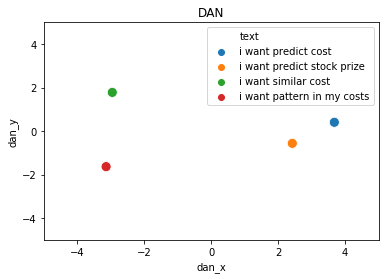

In [43]:
ax = sns.scatterplot(x = "dan_x", y="dan_y", data = _df, s=100, hue = "text")
title = ax.set_title("DAN")
ax.set(ylim=(-5, 5))
ax.set(xlim=(-5, 5))

## Pertubation
As used in:  http://cs.umd.edu/~miyyer/pubs/2015_acl_dan.pdf 

In [44]:
layers = [dense_layer_1, dense_layer_2, dense_layer_3, dense_layer_4]
for i,layer in enumerate(layers): 
    _df["layer_{}".format(i)] = _df["text"].apply(lambda text: np.linalg.norm(get_dan_embedding(text, layers[i])))

INFO:tensorflow:Restoring parameters from dan_checkpoints/first_dan.ckpt
INFO:tensorflow:Restoring parameters from dan_checkpoints/first_dan.ckpt
INFO:tensorflow:Restoring parameters from dan_checkpoints/first_dan.ckpt
INFO:tensorflow:Restoring parameters from dan_checkpoints/first_dan.ckpt
INFO:tensorflow:Restoring parameters from dan_checkpoints/first_dan.ckpt
INFO:tensorflow:Restoring parameters from dan_checkpoints/first_dan.ckpt
INFO:tensorflow:Restoring parameters from dan_checkpoints/first_dan.ckpt
INFO:tensorflow:Restoring parameters from dan_checkpoints/first_dan.ckpt
INFO:tensorflow:Restoring parameters from dan_checkpoints/first_dan.ckpt
INFO:tensorflow:Restoring parameters from dan_checkpoints/first_dan.ckpt
INFO:tensorflow:Restoring parameters from dan_checkpoints/first_dan.ckpt
INFO:tensorflow:Restoring parameters from dan_checkpoints/first_dan.ckpt
INFO:tensorflow:Restoring parameters from dan_checkpoints/first_dan.ckpt
INFO:tensorflow:Restoring parameters from dan_check

[1.26381174 1.28828307 1.67969674 3.40001111]
[1.29637451 1.31091004 1.64902928 3.26000511]
[1.22822768 1.28830832 1.78456619 3.69376751]
[1.22707313 1.32968001 1.85823389 3.84094202]


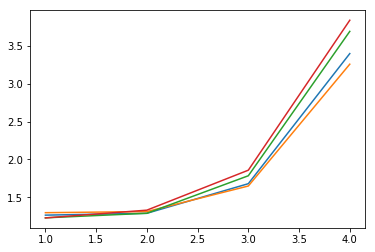

In [45]:
for i in range(0,len(layers)):
    x = [x+1 for x in range(0,len(layers))]
    y = _df.drop(columns = ["text","ft_embedding", "dan_embedding", "ft_x", "ft_y", "dan_x", "dan_y"]).T.values[:,i]
    print(y)
    ax = sns.lineplot(x = range(1, len(layers)+1), y = y, markers = "x")
    #ax.set(xlim = (0,len(layers)+1))

## Density Plots on Dataset

In [47]:
#df = df.drop(columns = ["x","y","z"])

In [56]:
%%time
tf.logging.set_verbosity(tf.logging.ERROR)
#df["embedding"] = df["text"].apply(lambda x: get_dan_embedding(word_tokenize(x), layers[-1]))

CPU times: user 72 µs, sys: 311 µs, total: 383 µs
Wall time: 280 µs


In [49]:
pca = PCA(n_components=2)
matrix = pca.fit_transform(df["embedding"].apply(lambda x: x[0]).tolist())

In [50]:
matrix.shape

(9156, 2)

In [51]:
df["x"] = matrix[:,0]
df["y"] = matrix[:,1]
#df["z"] = matrix[:,2]

In [52]:
df.head()

,text,class,embedding,x,y
154,in the present work the techniques of data min...,prediction,"[[-0.3355638357840839, -0.13896291549960116, -...",3.883821,2.471886
1044,but mere traditional urban and rural land clas...,prediction,"[[-0.4095738417188059, -0.030257054046782517, ...",3.714581,3.098291
2422,based on the class of algorithm to be used in ...,prediction,"[[-0.26437180314109704, -0.10844077346145818, ...",3.595108,3.499652
2900,however image clustering is a hard task mainly...,clustering,"[[-0.680087947850376, -0.4902574324514204, 0.6...",4.800903,-2.826970
5589,frequent pattern mining based on linear prefix...,pattern_mining,"[[0.26148430063823214, -0.14276555655640655, -...",-6.226912,0.166970


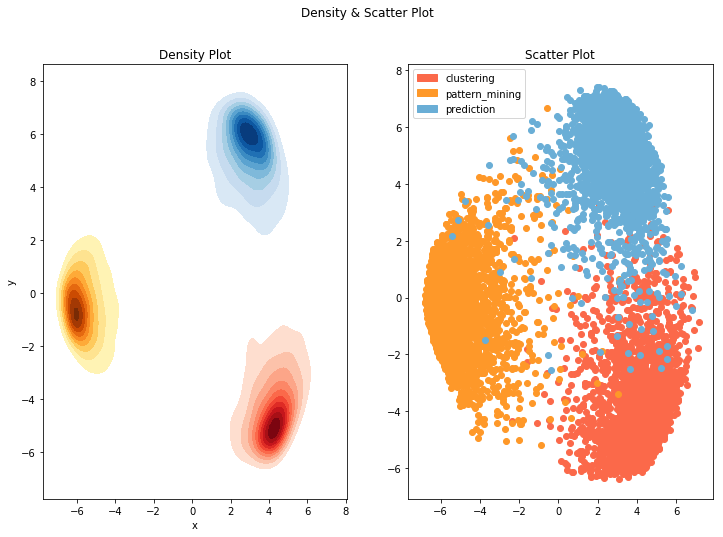

In [53]:
import matplotlib.patches as mpatches
import matplotlib

cmaps = cmaps = ["Reds","YlOrBr", "Blues","Greens"]
#colors = ["red", "blue", "purple", "green", "", "grey"]
groups = df.groupby("class")
counter = 0

fig = plt.figure(figsize=(12,8))
fig.suptitle("Density & Scatter Plot")

ax_1 = fig.add_subplot(1,2,1)
ax_2 = fig.add_subplot(1,2,2)

ax_1.set_title("Density Plot")
ax_2.set_title("Scatter Plot")


labels = []
for name, group in groups: 
    # Change that ax = ax_1
    ax = sns.kdeplot(group.x,group.y, shade=True, cmap = cmaps[counter],shade_lowest=False, ax = ax_1)
    color_from_cmap = matplotlib.cm.get_cmap(cmaps[counter])(0.5)
    
    ax_2.scatter(group.x, group.y, color = color_from_cmap)
    labels.append(mpatches.Patch(color=color_from_cmap, label=name))
    counter +=1
legend = plt.legend(handles = labels)